In [115]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
import astropy.io.ascii as ascii
import time
from scipy.optimize import curve_fit
import emcee
import pickle
import os
from multiprocessing import Pool
from multiprocessing import cpu_count
os.environ["OMP_NUM_THREADS"] = "1"
import corner


#np.random.seed(666)

## Name of galaxy

In [116]:
#galaxy='IC5332'
#galaxy='NGC0628'
#galaxy='NGC1087'
#galaxy='NGC1365' 
galaxy='NGC1512'
#galaxy='NGC1672'
#galaxy='NGC2835'
#galaxy='NGC3351'
#galaxy='NGC3627'
#galaxy='NGC5068'


## Function that calculates the 2-point cross-correlation function

In [117]:
def w(x1, y1, x2, y2, xr, yr, rmin=0, rmax=5000, dr=25):

    ddarr=cdist(np.transpose(np.array([x1,y1])), np.transpose(np.array([x2,y2]))).ravel()  
    drarr=cdist(np.transpose(np.array([x1,y1])), np.transpose(np.array([xr,yr]))).ravel()

    # Count pairs in distance bins       
    N1=len(x1)
    N2=len(x2)
    Nr=len(xr)
    bins=np.arange(rmin+dr/2, rmax, dr) # centers of bins for output

    dd0, dd0bins = np.histogram(ddarr, bins=np.arange(rmin, rmax+dr, dr)) #here bins are bin edges
    dr0, dr0bins = np.histogram(drarr, bins=np.arange(rmin, rmax+dr, dr))
    
    # Normalize pair counts and compute cross-correlation function
    if (N1!=0)*(N2!=0)*(Nr!=0):
        dd=dd0/N1/N2
        dr=dr0/N1/Nr
        omega=dd/dr-1
    
        edd=np.sqrt(dd0)/N1/N2
        edr=np.sqrt(dr0)/N1/Nr

        eomega=np.sqrt((edd/dr)**2+(dd*edr/dr**2)**2)
    else:
        omega=np.repeat(np.nan, len(bins))
        eomega=np.repeat(np.nan, len(bins))
        
    return (bins, omega, eomega)


## Functions that draws N model GMCs and returns properties

In [118]:
# This version just uses the observed GMC coordinates and assumes constant parameters for all clouds

def drawgmc_xy(x,y,rc=25,tc=30,ts=10,tfb=5,Ng=1,voff=10):

    ngmc=len(x) # number of GMCs
    
    xgmc=x # gmc x coordinates [pc]
    ygmc=y # gmc y coordinates [pc]
    
    rc=np.repeat(rc,ngmc) # gmc radius [pc]
    tc=np.repeat(tc,ngmc) # gmc lifetime [Myr]
    ts=np.repeat(ts,ngmc) # stellar SF tracer lifetime [Myr]
    tfb=np.repeat(tfb,ngmc) # stellar SF tracer emergence time [Myr]
    Ng=np.repeat(Ng,ngmc).astype(int) # number of massive SF episodes during gmc lifetime
    voff=np.repeat(voff,ngmc) # stellar SF tracer centorid to GMC centroid offset speed [km/s]

    tobs=np.random.uniform(0, tc-tfb+ts, ngmc) # random observation time for this cloud (between zero and tc+ts)
    fgmc=np.repeat(True, ngmc) # GMC visibility flag
    fgmc[tobs > tc]=False # visibility flag is False if GMC has faded

    return (xgmc, ygmc, rc, tc, ts, tfb, Ng, voff, tobs, fgmc)
    

In [119]:
# This version samples GMC coordinates with a typical separation scale "l" within a dbox**2 kpc**2 box, and assumes constant parameters for all clouds
# Also returns random catalog coordinates over the same area and Frand*Ngmc points
def drawgmc_l(dbox=2000,l=200,rc=25,tc=30,ts=10,tfb=5,Ng=1,voff=10, frand=10):

    area=dbox**2
    ngmc=int(area/l**2) # number of GMCs
    
    xgmc=np.random.uniform(-0.5*dbox, 0.5*dbox, ngmc) # gmc x coordinates [pc]
    ygmc=np.random.uniform(-0.5*dbox, 0.5*dbox, ngmc) # gmc y coordinates [pc]

    xr=np.random.uniform(-0.5*dbox, 0.5*dbox, frand*ngmc) # gmc x coordinates [pc]
    yr=np.random.uniform(-0.5*dbox, 0.5*dbox, frand*ngmc) # gmc y coordinates [pc]

    rc=np.repeat(rc,ngmc) # gmc radius [pc]
    tc=np.repeat(tc,ngmc) # gmc lifetime [Myr]
    ts=np.repeat(ts,ngmc) # stellar SF tracer lifetime [Myr]
    tfb=np.repeat(tfb,ngmc) # stellar SF tracer emergence time [Myr]
    Ng=np.repeat(Ng,ngmc).astype(int) # number of massive SF episodes during gmc lifetime
    voff=np.repeat(voff,ngmc) # stellar SF tracer centorid to GMC centroid offset speed [km/s]
    tobs=np.random.uniform(0, tc-tfb+ts, ngmc) # random observation time for this cloud (between zero and tc+ts)
    fgmc=np.repeat(True, ngmc) # GMC visibility flag
    fgmc[tobs > tc]=False # visibility flag is False if GMC has faded

    #print("Generating GMC and random coordinates:", ngmc, frand*ngmc)
    return (xgmc, ygmc, rc, tc, ts, tfb, Ng, voff, tobs, fgmc, xr, yr)
    

## Function that draws N*Ng HII regions given an ensemble of GMCs

In [120]:
def drawhii(xgmc, ygmc, rc, tc, ts, tfb, Ng, voff, tobs, fgmc):
    
    ngmc=len(xgmc) # number of GMCs
    nhii=np.sum(Ng.astype(int)) # number of HII regions
    voffaux=voff*3.2e-14*(1e6*365*24*3600) # velocity in pc/Myr

    xhii=np.zeros(nhii) # HII region initial coordinates
    yhii=np.zeros(nhii)
    t0=np.zeros(nhii) # HII region formation time
    fhii=np.repeat(False,nhii) # HII region visibility flag
    indgmc=np.zeros(nhii) # gmc list index

    k=0 # counter
    for i in range(ngmc):  # drawing HII regions for each GMC independently
        for j in range(Ng[i]):

            # initial position
            r0=rc[i]*np.sqrt(np.random.uniform(0,1)) # uniform across circular area
#            r0=rc[i]*np.random.uniform(0,1) # uniform in radius (i.e. as r**-2)
            theta0=np.random.uniform(0, 2*np.pi)
            x0=xgmc[i]+r0*np.cos(theta0)
            y0=ygmc[i]+r0*np.sin(theta0)

            #formation time (assuming stars form no later than tc-tfb)
            t0[k]=np.random.uniform(0, tc[i]-tfb[i])    
            
            #offset direction and final position at tobs
            phi=np.random.uniform(0, 2*np.pi)
            xhii[k]=x0+voffaux[i]*(tobs[i]-t0[k])*np.cos(phi)
            yhii[k]=y0+voffaux[i]*(tobs[i]-t0[k])*np.sin(phi)

            #visibility flag is True if cloud has already formed and emerged, and has not yet faded
            if (t0[k]+tfb[i]<tobs[i])*(tobs[i]<t0[k]+ts[i]):
                fhii[k]=True

                #print(t0[k], tfb[i], ts[i], tobs[i], t0[k]+tfb[i], t0[k]+ts[i], fhii[k])
            
            #GMC list index
            indgmc=i
            
            k=k+1
        
    
    return (xhii,yhii,fhii)
    
    
    

## Linear Model

In [121]:
def lin(x, a, b):
    return a+b*x

## Read GMC and Random catalogs coordinates

In [122]:
xygmc=ascii.read('./output/'+galaxy+'_xy_gmc.txt')
x1=xygmc['col0'].data
y1=xygmc['col1'].data

xyrand=ascii.read('./output/'+galaxy+'_xy_rand.txt')
xr=xyrand['col0'].data
yr=xyrand['col1'].data


## Read Observed Correlation Function

In [123]:
obscorr=ascii.read('./output/'+galaxy+'_corr.txt')
r0obs=obscorr['col0'].data
w0obs=obscorr['col1'].data
ew0obs=obscorr['col2'].data

## Fit and remove large scale (few kpc) correlation using linear model

[ 6.96182597e-01 -3.14242373e-04]


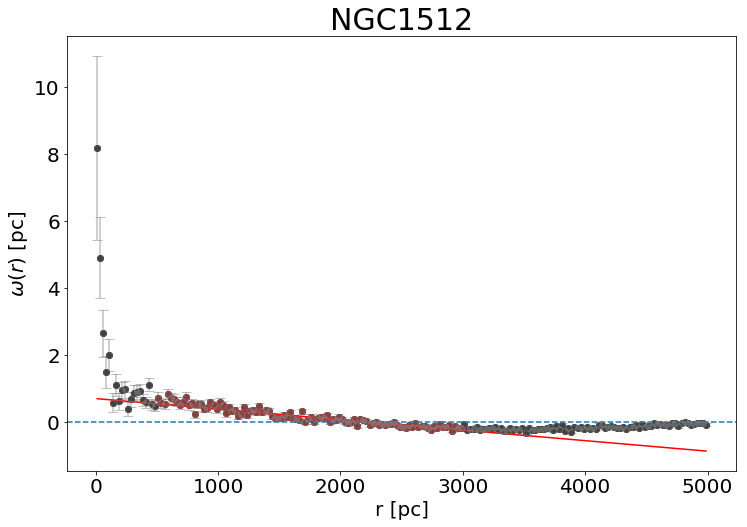

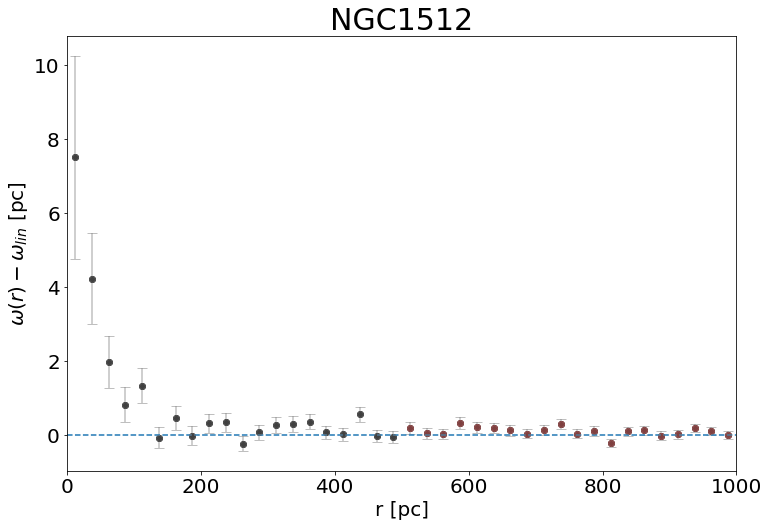

In [124]:
rmin=500
rmax=3000
sel=(r0obs>=rmin)*(r0obs<=rmax)
popt, pcov = curve_fit(lin, r0obs[sel], w0obs[sel], sigma=ew0obs[sel])
#print(popt)
w0small=w0obs-lin(r0obs, *popt)




#plot large scale fit

fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(r0obs, w0obs, ew0obs, fmt="o", color='grey', capsize=5, alpha=0.5)
ax.plot(r0obs, w0obs, 'o', color='black', alpha=1.0)
ax.plot(r0obs[sel], w0obs[sel], 'o', color='red', alpha=0.5)
ax.plot(r0obs, lin(r0obs, *popt), color='red')
#ax.set_ylim(1e-3, 2e0)
ax.axhline(y=0, linestyle='--')
plt.xlabel('r [pc]', fontsize=20)
plt.ylabel(r'$\omega(r)$ [pc]', fontsize=20)
plt.title(galaxy, fontsize=30)
ax.tick_params(labelsize=20)
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.savefig('./plots/'+galaxy+'_corr_linfit.png')
#plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(r0obs, w0small, ew0obs, fmt="o", color='grey', capsize=5, alpha=0.5)
ax.plot(r0obs, w0small, 'o', color='black', alpha=1.0)
ax.plot(r0obs[sel], w0small[sel], 'o', color='red', alpha=0.5)
ax.set_xlim(0, 1e3)
#ax.set_ylim(1e-3, 2e0)
ax.axhline(y=0, linestyle='--')
plt.xlabel('r [pc]', fontsize=20)
plt.ylabel(r'$\omega(r)-\omega_{lin}$ [pc]', fontsize=20)
plt.title(galaxy, fontsize=30)
ax.tick_params(labelsize=20)
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.savefig('./plots/'+galaxy+'_corr_small.png')
#plt.show()



## Function that Evaluates Cross Correlation Function for Model Parameters

In [125]:
def eval_w(l0, rc0, tc0, ts0, tfb0, Ng0, voff0):
    
    t0=time.time()
    
    print("Evaluating Model:")
    print("l=", l0)
    print("rc=", rc0)
    print("tc=", tc0)
    print("ts=", ts0)
    print("tfb=", tfb0)
    print("Ng=", Ng0)
    print("voff=", voff0)

    Nsamples=500
#    Nsamples=10

    
    # Run w() one time to get bins
    xgmc, ygmc, rc, tc, ts, tfb, Ng, voff, tobs, fgmc, xr, yr = drawgmc_l(dbox=2000, l=l0, rc=rc0, tc=tc0, ts=ts0, tfb=tfb0, Ng=Ng0, voff=voff0, frand=10)
    xhii, yhii, fhii = drawhii(xgmc, ygmc, rc, tc, ts, tfb, Ng, voff, tobs, fgmc)
    r0, w0, ew0 = w(xgmc[fgmc], ygmc[fgmc], xhii[fhii], yhii[fhii], xr, yr, rmax=1000)   
    w0arr=np.zeros((len(w0),Nsamples))
    ew0arr=np.zeros((len(ew0),Nsamples))
    
   
    # Run w() Nsample times and average
    for i in range(Nsamples):
    
        xgmc, ygmc, rc, tc, ts, tfb, Ng, voff, tobs, fgmc, xr, yr = drawgmc_l(dbox=2000, l=l0, rc=rc0, tc=tc0, ts=ts0, tfb=tfb0, Ng=Ng0, voff=voff0, frand=10)
        xhii, yhii, fhii = drawhii(xgmc, ygmc, rc, tc, ts, tfb, Ng, voff, tobs, fgmc)
        r0, w0arr[:,i], ew0arr[:,i] = w(xgmc[fgmc], ygmc[fgmc], xhii[fhii], yhii[fhii], xr, yr, rmax=1000)
        
    w0arr[~np.isfinite(w0arr)]=np.nan
    ew0arr[~np.isfinite(ew0arr)]=np.nan    
    w0=np.nanmean(w0arr, axis=1)
    ew0=np.nanmean(ew0arr, axis=1)/np.sqrt(Nsamples)
    
    
    print("Model Evaluation Run Time [s] =", time.time()-t0)

    
  
    fig, ax = plt.subplots(figsize=(12, 8))
    #for i in range(Nsamples):
    #    ax.plot(r0, w0arr[:,i], 'o', color='red', alpha=0.5)
    #for i in range(Ntest):
    #    ax.plot(r0, w0test[:,i], 'o', color='green', alpha=0.5)
    ax.plot(r0, w0, 'o', color='green', alpha=1.0)    
    ax.errorbar(r0obs, w0small, ew0obs, fmt="o", color='black', capsize=5, alpha=0.5)
    ax.plot(r0obs, w0small, '-o', color='black', alpha=0.5)
    ax.set_xlim(0, 1000)
    ax.axhline(y=0, linestyle='--')
    ax.set_xlabel('r [pc]', fontsize=20)
    ax.set_ylabel(r'$\omega(r)$ [pc]', fontsize=20)
    ax.set_title(galaxy, fontsize=30)
    ax.tick_params(labelsize=20)
    #ax.set_yscale('log')
    #ax.set_ylim(-0.2, 4)
#    plt.savefig('./plots/'+galaxy+'_corr_model.png')
#    plt.show()
    
    fig, ax = plt.subplots(figsize=(12, 12))
    #ax.plot(xgmc, ygmc, '.', color='blue', alpha=0.4)
    ax.plot(xgmc[fgmc], ygmc[fgmc], 'o', color='blue', label='GMC')
    #ax.plot(xhii, yhii, '.', color='red', alpha=0.4)
    ax.plot(xhii[fhii], yhii[fhii], 'o', color='red', label='HII')
    #ax.set_xlim(-1000, 1000)
    #ax.set_ylim(-1000, 1000)
    ax.set_xlabel('X [pc]', fontsize=20)
    ax.set_ylabel('Y [pc]', fontsize=20)
    ax.set_title(galaxy, fontsize=30)
    ax.tick_params(labelsize=20)
    ax.legend(fontsize=20)
#    plt.savefig('./plots/'+galaxy+'_xy_model.png')
#    plt.show()


    
    return (w0, ew0)


# Define Priors and Likelihood Functions

In [126]:
# Trim observed corr function to <=1kpc
selr=(r0obs<=1000)


def log_prior(p):
    l1, rc1, tc1, ts1, tfb1, Ng1, voff1 = p
    if 10<l1<300 and 5<rc1<100 and 1<tc1<500 and 1<ts1<20 and 1<tfb1<20 and 1<Ng1<10 and 0<voff1<30:
        return 0.0
    else:
        return -np.inf

def log_prob(p):
    lprior=log_prior(p)
    if np.isfinite(lprior):
        w0, ew0 = eval_w(l0=p[0], rc0=p[1], tc0=p[2], ts0=p[3], tfb0=p[4], Ng0=p[5], voff0=p[6])
        res=w0-w0small[selr]
        sig=ew0obs[selr]
        prob=1/(2*np.pi*sig**2)*np.exp(-0.5*(res/sig)**2)
        logp=lprior+np.sum(np.log(prob))
        if not np.isfinite(logp):
#        print("fail2")
            return -np.inf
        return logp
    else:
        return -np.inf

        



# Set up MCMC

In [127]:
ndim=7
nwalkers=16

p0 = np.zeros((nwalkers, ndim))
p0[:,0]=np.random.uniform(50, 200, nwalkers)
p0[:,1]=np.random.uniform(20, 100, nwalkers)
p0[:,2]=np.random.uniform(1, 500, nwalkers)
p0[:,3]=np.random.uniform(5, 15, nwalkers)
p0[:,4]=np.random.uniform(1, 10, nwalkers)
p0[:,5]=np.random.uniform(1, 10, nwalkers)
p0[:,6]=np.random.uniform(0, 30, nwalkers)

# Run MCMC Chain

In [128]:
Nmc=1000

print("Starting MCMC")
t0full=time.time()


with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
    state = sampler.run_mcmc(p0,Nmc)
    
print("MCMC Total Run Time [s] =", time.time()-t0full)


Evaluating Model:
Evaluating Model:
Evaluating Model:
l= 68.1955467267485
l= 120.38769915740474
Evaluating Model:
l= 75.79076443147383
rc= 34.86906635959823
rc= 73.09119976841632
l= 90.83359535376411
rc= 60.82145401971735
tc= 49.82436181219149
tc= 49.9612241784491
rc= 99.15472776648974
tc= 38.31346376294072
ts= 7.5874033070910185
ts= 5.20246264160947
tc= 56.60204848337755
tfb= 3.032098179660931
ts= 10.532956720459737
tfb= 6.528976612051183
Ng= 6.366078871920042
tfb= 3.3920062405841067
ts= 5.1961153167811345
tfb= 9.852466135738524
Ng= 3.0510814358055294
Ng= 2.3369757931542923
Ng= 5.105363065986139
voff= 4.013100647667551
voff= 1.1373475952223733
voff= 29.81679763102698
voff= 1.153016362118393
Model Evaluation Run Time [s] = 2.12479305267334
Evaluating Model:
l= 171.21531935971825
rc= 98.34298636329281
tc= 399.7900904597664
ts= 9.017479093863518
tfb= 1.2587305630655137
Ng= 5.086651825896285
voff= 9.330808440383406
Model Evaluation Run Time [s] = 0.6381418704986572
Evaluating Model:
l= 19

/Users/gblancm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/Users/gblancm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice


Model Evaluation Run Time [s] = 4.36383318901062
Evaluating Model:
l= 139.82273453142705
rc= 22.36754556819203
tc= 74.59156086334634
ts= 6.2845150404639005
tfb= 5.620024807493687
Ng= 2.2677863614478797
voff= 27.804358257563013
Model Evaluation Run Time [s] = 0.8122081756591797
Evaluating Model:
l= 138.96932331636816
rc= 92.86125700388583
tc= 153.30429321281855
ts= 12.851262850473695
tfb= 8.845099200558598
Ng= 3.7042919162341827
voff= 7.6494485081409636
Model Evaluation Run Time [s] = 0.6981420516967773
Evaluating Model:
l= 108.48407531956525
rc= 22.427383899682933
tc= 256.9428276358667
ts= 8.809961790532327
tfb= 1.14528375794721
Ng= 4.424100654217302
voff= 4.764690039071807
Model Evaluation Run Time [s] = 7.833120107650757
Evaluating Model:
l= 192.89124458778736
rc= 64.6153443967954
tc= 188.3725211875188
ts= 5.75064497794375
tfb= 6.715038825436258
Ng= 8.60440218598847
voff= 24.35490913534513
Model Evaluation Run Time [s] = 1.7676060199737549
Evaluating Model:
l= 50.967534228792
rc= 81.

/Users/gblancm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/Users/gblancm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice


Model Evaluation Run Time [s] = 0.4161388874053955
Evaluating Model:
l= 184.20833044158275
rc= 63.66509023169422
tc= 488.1587322908859
ts= 14.816217665944613
tfb= 4.170778399853639
Ng= 4.769027759046333
voff= 0.17904864157304634
Model Evaluation Run Time [s] = 0.34561824798583984
Evaluating Model:
l= 119.35145068909948
rc= 61.09145283378475
tc= 374.2830235574233
ts= 9.330221327628115
tfb= 8.321915672744025
Ng= 2.3817475752125055
voff= 5.542880829792437
Model Evaluation Run Time [s] = 1.0835089683532715
Evaluating Model:
l= 147.27555565846507
rc= 21.32470602734913
tc= 402.3572848848491
ts= 14.729778555566735
tfb= 5.691832326131813
Ng= 2.391121114285026
voff= 9.14898011551492
Model Evaluation Run Time [s] = 0.5111539363861084


/Users/gblancm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/Users/gblancm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice


Model Evaluation Run Time [s] = 11.226290941238403
Model Evaluation Run Time [s] = 8.631679058074951
Model Evaluation Run Time [s] = 25.513123273849487
Evaluating Model:
Evaluating Model:
l= 90.56707216958527
l= 169.4678481855611
rc= 43.46858947338271
rc= 48.530336967111936
tc= 137.1267889789752
tc= 230.13811731493098
ts= 9.75421933889075
ts= 9.33517374938852
tfb= 7.232078704738762
tfb= 2.376561126468453
Ng= 4.797454727146983
Ng= 2.5844417236249697
voff= 18.494063982724466
voff= 27.879104307944615
Model Evaluation Run Time [s] = 0.5839800834655762
Model Evaluation Run Time [s] = 2.8512320518493652
Evaluating Model:
Evaluating Model:
Evaluating Model:
Evaluating Model:
l= 140.01859867213852
l= 126.68900287830371
l= 101.35910625394702
l= 186.56856032921664
rc= 22.841570389910316
rc= 90.77363679213101
rc= 53.39991000646735
rc= 60.273513625191896
tc= 76.6205346133076
tc= 59.434512618817394
tc= 176.07126738316796
ts= 6.3015665084727415
tc= 199.64632079582464
ts= 7.351160421772944
ts= 14.311

/Users/gblancm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/Users/gblancm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice


Model Evaluation Run Time [s] = 0.5344929695129395
Evaluating Model:
l= 50.79788476199307
rc= 79.5859745821505
tc= 475.0930287867035
ts= 10.981100190033114
tfb= 6.4847635494106335
Ng= 6.141310526940288
voff= 21.852474265698913
Model Evaluation Run Time [s] = 0.9342169761657715
Evaluating Model:
l= 109.1887911114641
rc= 46.256648817622
tc= 232.6351772026848
ts= 10.141202468111949
tfb= 6.095020410458022
Ng= 2.7089732960901456
voff= 5.29039226809882
Model Evaluation Run Time [s] = 1.552274227142334
Model Evaluation Run Time [s] = 3.275597095489502
Model Evaluation Run Time [s] = 2.3074448108673096
Model Evaluation Run Time [s] = 26.30474281311035
Evaluating Model:
Evaluating Model:
l= 99.74549787705003
l= 122.57629785577728
Evaluating Model:
rc= 51.0178777739953
rc= 54.286106943742965
tc= 61.67194823066609
l= 71.11296119134981
tc= 53.162204975787596
rc= 64.33352370704951
ts= 9.922776209993927
ts= 5.685269656479986
tc= 120.0635018341066
tfb= 6.054565362830651
tfb= 6.1177452947524555
ts= 10

# Pickle MCMC Chain

In [138]:
del(sampler.pool)

with open('mcmc.pkl', 'wb') as f:
    pickle.dump(sampler, f, pickle.HIGHEST_PROTOCOL)

# Unpickle MCMC Chain

In [139]:
with open('mcmc.pkl', 'rb') as f:
    sampler = pickle.load(f)

# Find best-fit model (max logP) and evaluate

(16, 2, 7)
[123.53835102  64.14021731 222.28582411   9.17385021   5.64232311
   3.80097256   9.23989428]
Best-fit Parameters: [1.84208330e+02 6.36650902e+01 4.88158732e+02 1.48162177e+01
 4.17077840e+00 4.76902776e+00 1.79048642e-01]
Evaluating Model:
l= 184.20833044158275
rc= 63.66509023169422
tc= 488.1587322908859
ts= 14.816217665944613
tfb= 4.170778399853639
Ng= 4.769027759046333
voff= 0.17904864157304634
Model Evaluation Run Time [s] = 0.19919633865356445


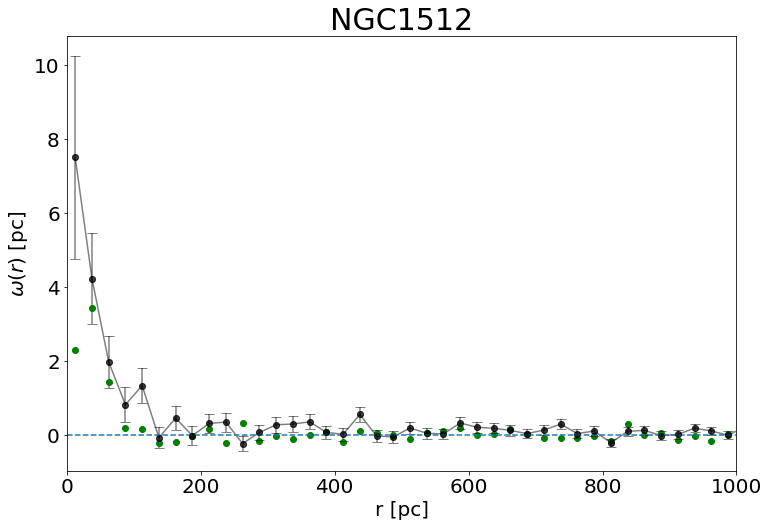

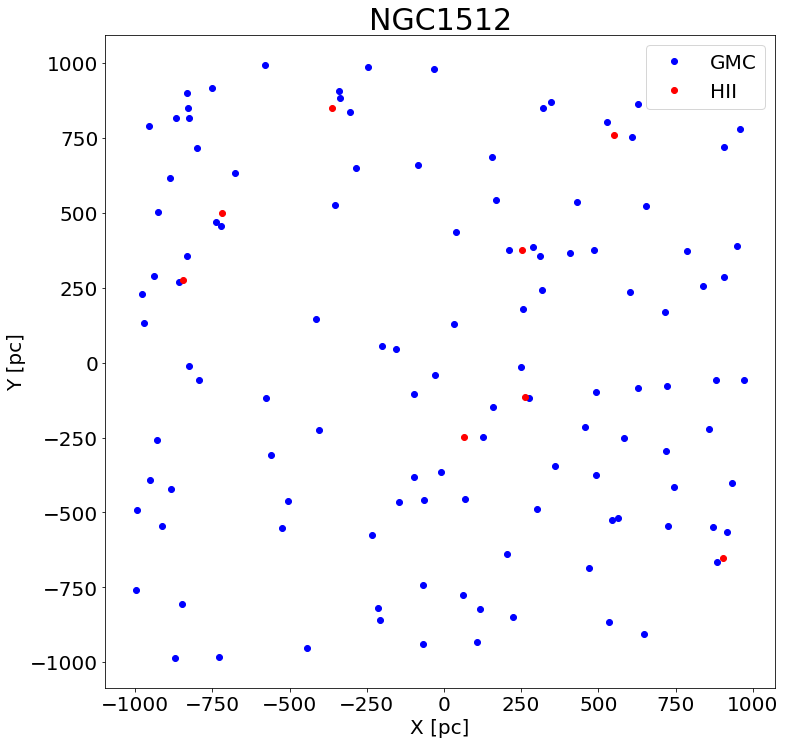

In [140]:
samples = sampler.chain
print(np.shape(samples))
print(np.median(samples[:,-1,:],axis=0))

logp=sampler.lnprobability
maxlogp=np.max(logp)
selbest=np.where(logp == maxlogp)
bestwalk=selbest[0][0]
bestsamp=selbest[1][0]
pbest=samples[bestwalk, bestsamp, :]
print("Best-fit Parameters:", pbest)

w0, ew0 = eval_w(l0=pbest[0], rc0=pbest[1], tc0=pbest[2], ts0=pbest[3], tfb0=pbest[4], Ng0=pbest[5], voff0=pbest[6])


# Make MCMC Plots

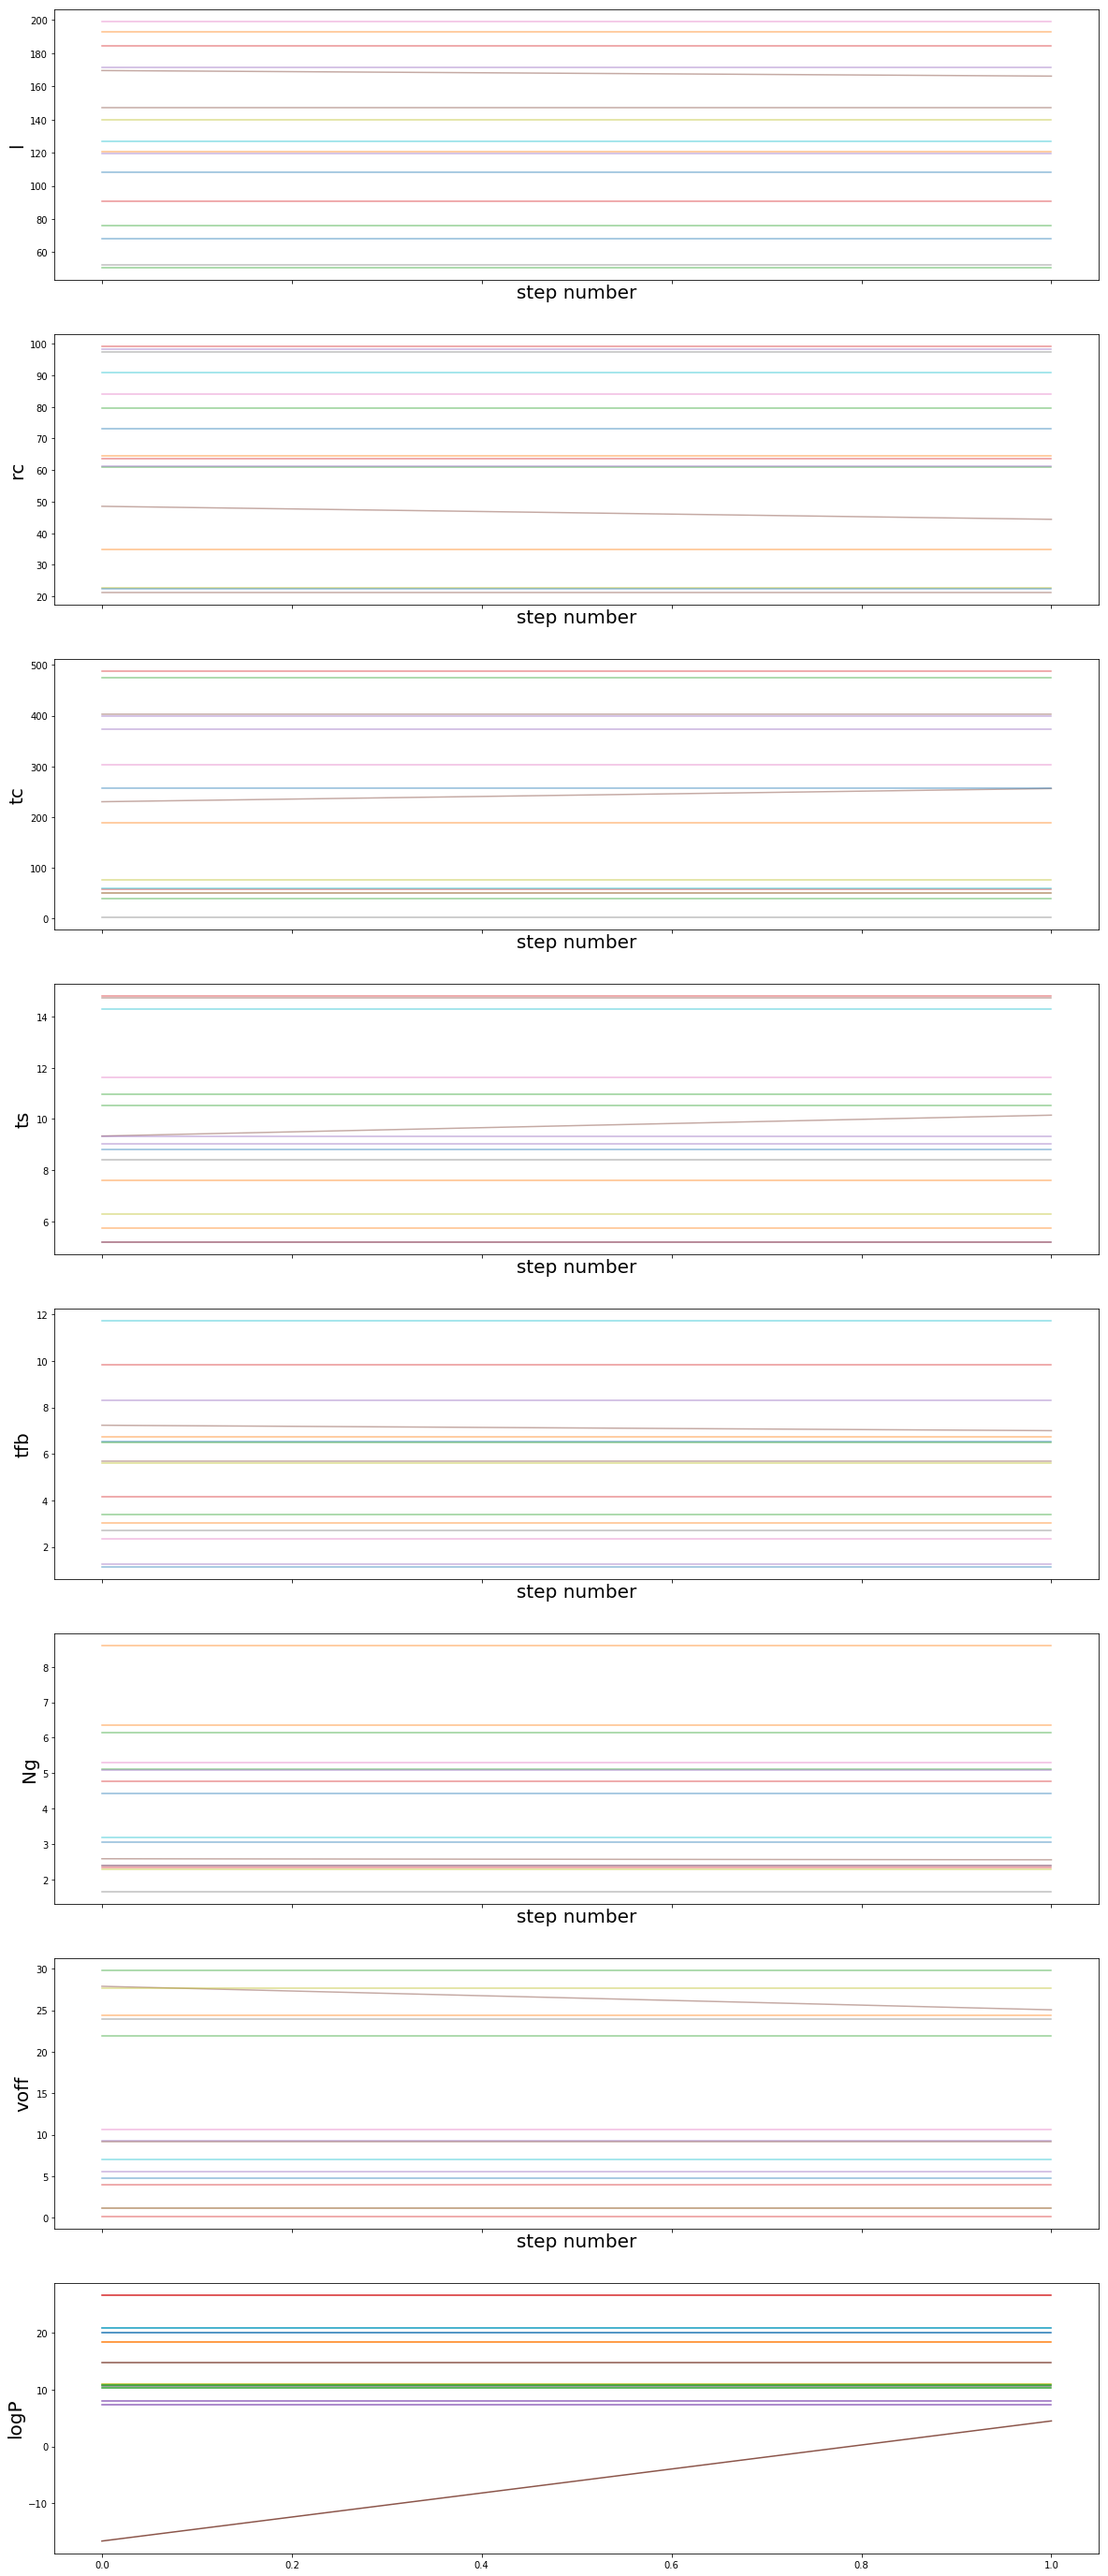

In [141]:
fig, axes = plt.subplots(8, figsize=(20, 50), sharex=True)
labels = ["l", "rc", "tc", "ts", "tfb", "Ng", "voff"]
for i in range(ndim):
    ax = axes[i]
    for j in range(nwalkers):
        ax.plot(samples[j, :, i], "-", alpha=0.5)
#    ax.set_xlim(0, Nmc)
#    ax.set_ylim(-20,100)
    ax.set_ylabel(labels[i], fontsize=20)
#    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlabel("step number", fontsize=20)
    
ax=axes[7]
for j in range(nwalkers):
    ax.plot(logp[j,:])
    ax.set_ylabel("logP", fontsize=20)
#    ax.set_ylim(100,150)

plt.savefig('./plots/'+galaxy+'_mcmc_samples.png')


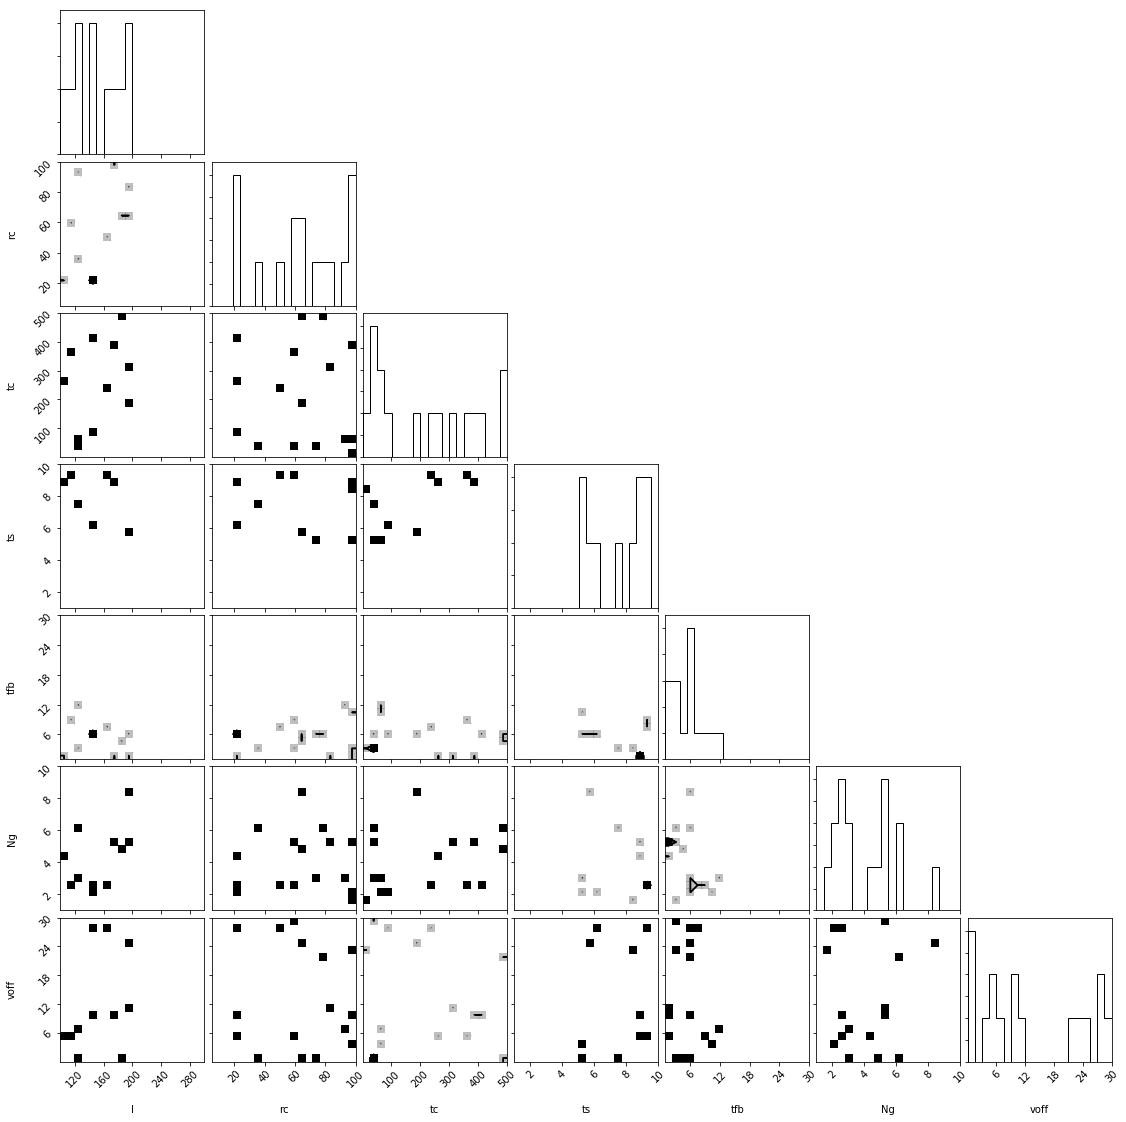

In [142]:
Nburn=0
goodsamples=samples[:,Nburn:-1,:]
flat_goodsamples=goodsamples.reshape((np.shape(goodsamples)[0]*np.shape(goodsamples)[1],np.shape(goodsamples)[2]))
fig = corner.corner(flat_goodsamples, labels=labels, range=[(100,300), (5,100), (1,500), (1,10), (1,30), (1, 10), (0,30)]);

plt.savefig('./plots/'+galaxy+'_mcmc_corner.png')


In [150]:
# Convert Notebook to Python Script
#ignore
!jupyter nbconvert --to script --RegexRemovePreprocessor.patterns="['#ignore']" gmc_hii_corr_model.ipynb
os.rename('gmc_hii_corr_model.txt', 'gmc_hii_corr_model.py')



[NbConvertApp] Converting notebook gmc_hii_corr_model.ipynb to script
[NbConvertApp] Writing 14428 bytes to gmc_hii_corr_model.py


FileNotFoundError: [Errno 2] No such file or directory: 'gmc_hii_corr_model.txt' -> 'gmc_hii_corr_model.py'